In [1]:
from binn import BINN, BINNDataLoader, BINNTrainer, BINNExplainer
import pandas as pd

# Load your data
data_matrix = pd.read_csv("../data/sample_datamatrix.csv")
design_matrix = pd.read_csv("../data/sample_design_matrix.tsv", sep="\t")

# Initialize BINN
binn = BINN(data_matrix=data_matrix, network_source="reactome", n_layers=4, dropout=0.2)

## Initialize DataLoader
binn_dataloader = BINNDataLoader(binn)

# Create DataLoaders
dataloaders = binn_dataloader.create_dataloaders(
    data_matrix=data_matrix,
    design_matrix=design_matrix,
    feature_column="Protein",
    group_column="group",
    sample_column="sample",
    batch_size=32,
    validation_split=0.2,
)
# Train the model
trainer = BINNTrainer(binn)
trainer.fit(dataloaders=dataloaders, num_epochs=100)

# Explain the model
explainer = BINNExplainer(binn)
single_explanations = explainer.explain_single(dataloaders, split="val", normalization_method="subgraph")
single_explanations


[INFO] BINN is on device: cpu
Mapping group labels: {np.int64(1): 0, np.int64(2): 1}
[Epoch 1/100] Train Loss: 0.9678, Train Accuracy: 0.4216
[Epoch 1/100] Val Loss: 0.6931, Val Accuracy: 0.5312
[Epoch 2/100] Train Loss: 0.9201, Train Accuracy: 0.4459
[Epoch 2/100] Val Loss: 0.6934, Val Accuracy: 0.4688
[Epoch 3/100] Train Loss: 0.9358, Train Accuracy: 0.5017
[Epoch 3/100] Val Loss: 0.6936, Val Accuracy: 0.4688
[Epoch 4/100] Train Loss: 0.9429, Train Accuracy: 0.4403
[Epoch 4/100] Val Loss: 0.6935, Val Accuracy: 0.4688
[Epoch 5/100] Train Loss: 0.8021, Train Accuracy: 0.5522
[Epoch 5/100] Val Loss: 0.6935, Val Accuracy: 0.4688
[Epoch 6/100] Train Loss: 0.8025, Train Accuracy: 0.5610
[Epoch 6/100] Val Loss: 0.6937, Val Accuracy: 0.4688
[Epoch 7/100] Train Loss: 0.8296, Train Accuracy: 0.5028
[Epoch 7/100] Val Loss: 0.6930, Val Accuracy: 0.4844
[Epoch 8/100] Train Loss: 0.7828, Train Accuracy: 0.5929
[Epoch 8/100] Val Loss: 0.6903, Val Accuracy: 0.5312
[Epoch 9/100] Train Loss: 0.7535, 

,source_layer,target_layer,source_node,target_node,class_idx,importance,normalized_importance
0,0,1,A0M8Q6,R-HSA-166663,0,0.002495,0.000514
1,0,1,A0M8Q6,R-HSA-166663,1,0.010029,0.002064
2,0,1,A0M8Q6,R-HSA-198933,0,0.002495,0.000514
3,0,1,A0M8Q6,R-HSA-198933,1,0.010029,0.002064
4,0,1,A0M8Q6,R-HSA-2029481,0,0.002495,0.000514
...,...,...,...,...,...,...,...
7079,4,5,R-HSA-9612973,output_node,1,0.252444,0.058410
7080,4,5,R-HSA-9709957,output_node,0,0.142352,0.030654
7081,4,5,R-HSA-9709957,output_node,1,0.144271,0.031067
7082,4,5,R-HSA-9748784,output_node,0,0.070675,0.017291


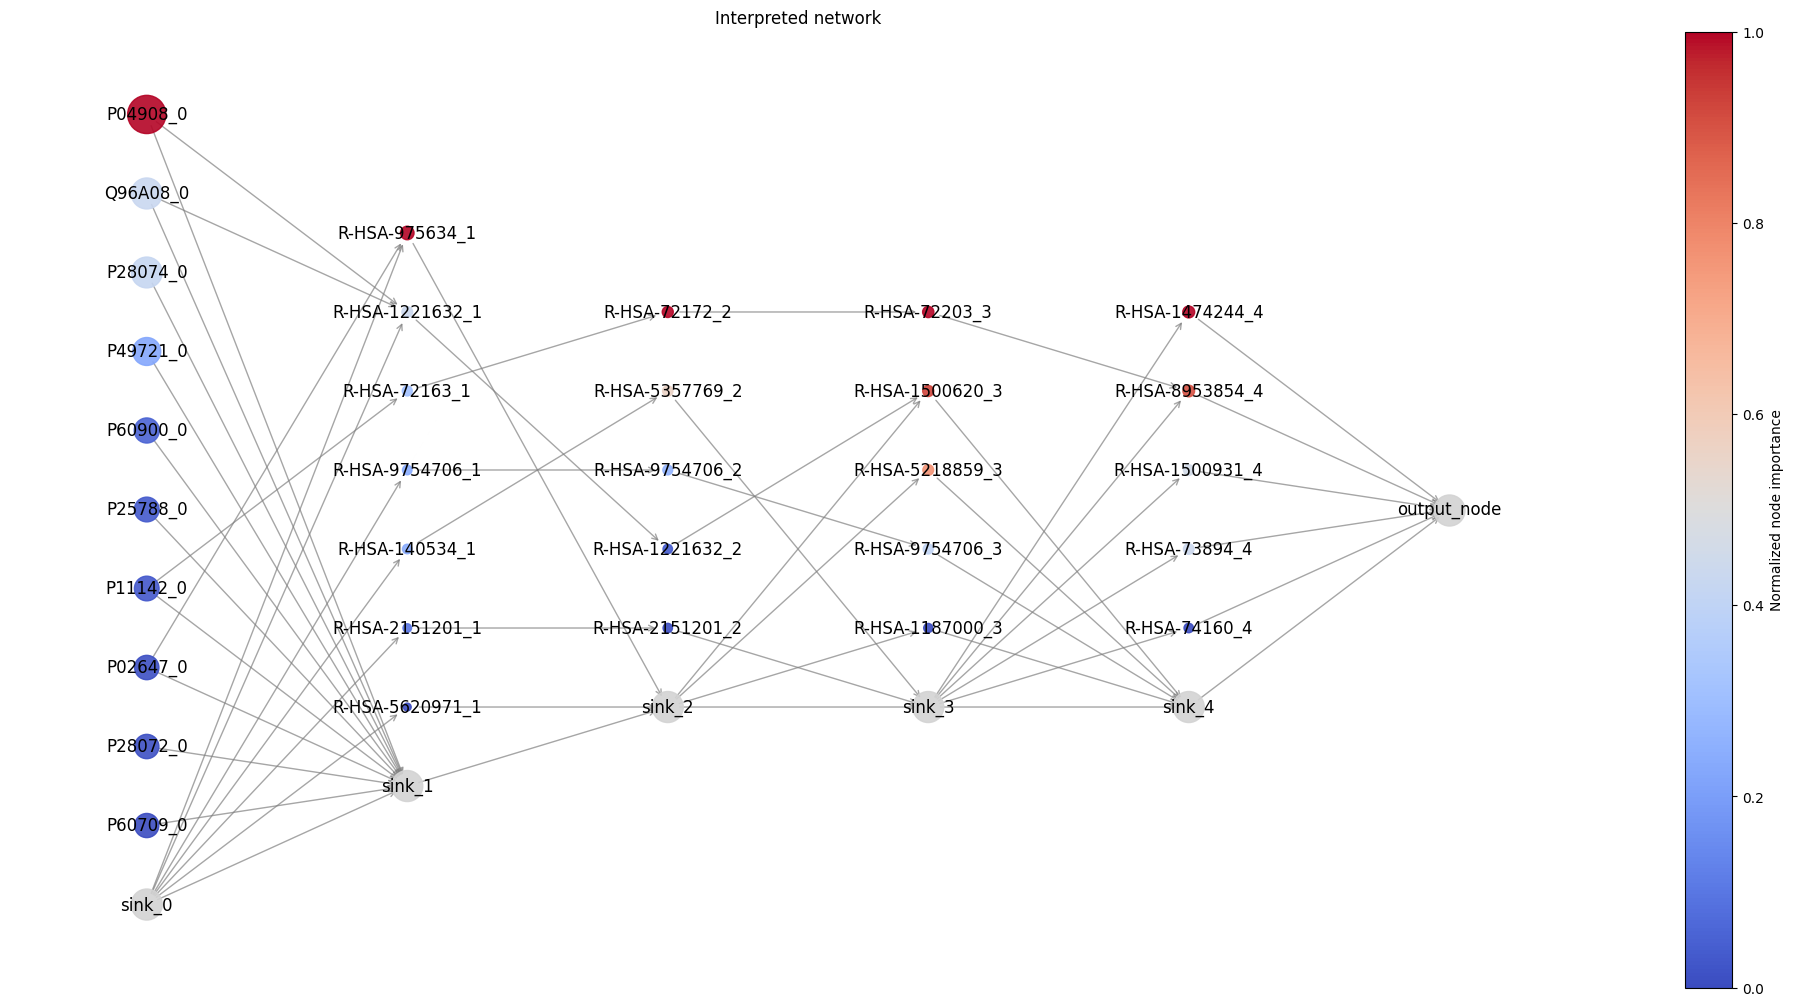

In [2]:
from binn.plot.network import visualize_binn

layer_specific_top_n = {"0": 10, "1": 7, "2": 5, "3":5, "4":5}
plt = visualize_binn(single_explanations, top_n=layer_specific_top_n, plot_size=(20,10), sink_node_size=500, node_size_scaling = 200, edge_width=1,  node_cmap="coolwarm")
plt.title("Interpreted network")
plt.savefig("./img/interpreted_binn.png")

In [4]:
average_explanations = explainer.explain(
    dataloaders, nr_iterations=3, num_epochs=50, trainer=trainer
)

[BINNExplainer] Iteration 1/3...
[Epoch 1/50] Train Loss: 0.5396, Train Accuracy: 0.7080
[Epoch 1/50] Val Loss: 0.6931, Val Accuracy: 0.7656
[Epoch 2/50] Train Loss: 0.5495, Train Accuracy: 0.7241
[Epoch 2/50] Val Loss: 0.6930, Val Accuracy: 0.8125
[Epoch 3/50] Train Loss: 0.4834, Train Accuracy: 0.7642
[Epoch 3/50] Val Loss: 0.6927, Val Accuracy: 0.7812
[Epoch 4/50] Train Loss: 0.4588, Train Accuracy: 0.8086
[Epoch 4/50] Val Loss: 0.6918, Val Accuracy: 0.6094
[Epoch 5/50] Train Loss: 0.4490, Train Accuracy: 0.8155
[Epoch 5/50] Val Loss: 0.6897, Val Accuracy: 0.5938
[Epoch 6/50] Train Loss: 0.4550, Train Accuracy: 0.7817
[Epoch 6/50] Val Loss: 0.6858, Val Accuracy: 0.9219
[Epoch 7/50] Train Loss: 0.4813, Train Accuracy: 0.7800
[Epoch 7/50] Val Loss: 0.6763, Val Accuracy: 0.9844
[Epoch 8/50] Train Loss: 0.4908, Train Accuracy: 0.7830
[Epoch 8/50] Val Loss: 0.6590, Val Accuracy: 0.8906
[Epoch 9/50] Train Loss: 0.4879, Train Accuracy: 0.7343
[Epoch 9/50] Val Loss: 0.6298, Val Accuracy: 0.

In [5]:
normalized_average_explanations = explainer.normalize_importances(average_explanations, method="fan")
normalized_average_explanations

,source_layer,target_layer,source_node,target_node,class_idx,importance,normalized_importance,importance_0,importance_1,importance_2,importance_mean,importance_std
0,0,1,A0M8Q6,R-HSA-166663,0,0.027221,0.006805,0.034115,0.018760,0.028787,0.027221,0.006366
1,0,1,A0M8Q6,R-HSA-166663,1,0.014085,0.003521,0.017963,0.012837,0.011453,0.014085,0.002800
2,0,1,A0M8Q6,R-HSA-198933,0,0.027221,0.006805,0.034115,0.018760,0.028787,0.027221,0.006366
3,0,1,A0M8Q6,R-HSA-198933,1,0.014085,0.003521,0.017963,0.012837,0.011453,0.014085,0.002800
4,0,1,A0M8Q6,R-HSA-2029481,0,0.027221,0.006805,0.034115,0.018760,0.028787,0.027221,0.006366
...,...,...,...,...,...,...,...,...,...,...,...,...
7079,4,5,R-HSA-9612973,output_node,1,0.180443,0.077712,0.189892,0.264919,0.086518,0.180443,0.073138
7080,4,5,R-HSA-9709957,output_node,0,0.207741,0.103870,0.313473,0.165449,0.144300,0.207741,0.075261
7081,4,5,R-HSA-9709957,output_node,1,0.152707,0.076354,0.129632,0.168368,0.160122,0.152707,0.016660
7082,4,5,R-HSA-9748784,output_node,0,0.102303,0.034101,0.109753,0.109547,0.087608,0.102303,0.010391
